In [103]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.dates as mdates


In [104]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [105]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [106]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [107]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [108]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [109]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [110]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [111]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


In [112]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)
one_year_ago


2016-08-23


datetime.date(2016, 8, 23)

In [113]:

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement).filter(
    measurement.date >= one_year_ago,
    measurement.date <= dt.date(2017, 8, 23),
).all()

# Collect the data in lists
ids = []
stations = []
dates = []
precipitations = []
temperatures = []

for result in results:
    ids.append(result.id)
    stations.append(result.station)
    dates.append(result.date)
    precipitations.append(result.prcp)
    temperatures.append(result.tobs)


In [114]:
# Save the query results as a Pandas DataFrame
last_year = pd.DataFrame({
    'ID': ids,
    'Station': stations,
    'Date': dates,
    'Precipitation': precipitations,
    'Temperature': temperatures,
})

# Print or use the DataFrame as needed
last_year.head()

,ID,Station,Date,Precipitation,Temperature
0,2364,USC00519397,2016-08-23,0.00,81.0
1,2365,USC00519397,2016-08-24,0.08,79.0
2,2366,USC00519397,2016-08-25,0.08,80.0
3,2367,USC00519397,2016-08-26,0.00,79.0
4,2368,USC00519397,2016-08-27,0.00,77.0


In [115]:
# Sort the dataframe by date
sorted_last_year = last_year.sort_values('Date', ascending=False)
sorted_last_year.head()

,ID,Station,Date,Precipitation,Temperature
2229,19550,USC00516128,2017-08-23,0.45,76.0
1528,12187,USC00519523,2017-08-23,0.08,82.0
1008,7635,USC00514830,2017-08-23,0.00,82.0
360,2724,USC00519397,2017-08-23,0.00,81.0
1527,12186,USC00519523,2017-08-22,0.00,82.0


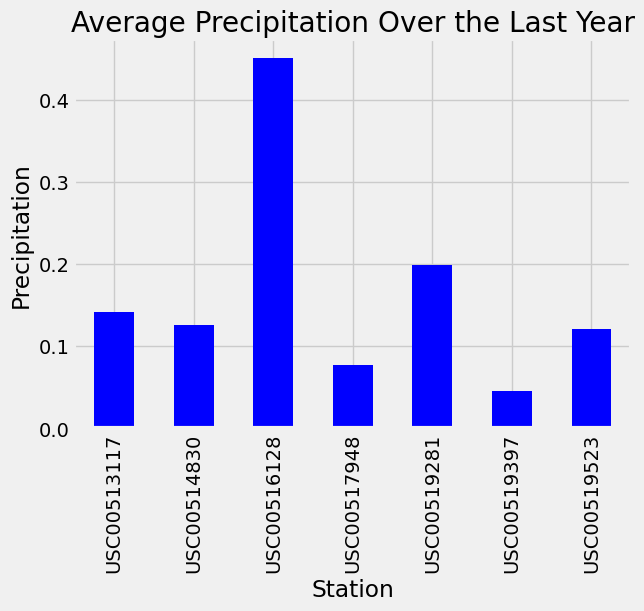

In [116]:
# Group by 'Station' and calculate average precipitation
average_precipitation = sorted_last_year.groupby('Station')['Precipitation'].mean().reset_index()

# Plot the average precipitation per station
average_precipitation.plot(x='Station', 
                           y='Precipitation', 
                           kind='bar',
                           title='Average Precipitation Over the Last Year', 
                           xlabel='Station', 
                           ylabel='Precipitation',
                           color='blue',  # Set your desired color
                           legend=False)  # Disable legend since it's a single bar plot

# Show the plot
plt.show()

In [117]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = sorted_last_year['Precipitation'].describe()

# Display the summary statistics
print(precipitation_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [118]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [129]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Design a query to find the most active stations and their row counts
active_stations_query = session.query(
    measurement.station,
    func.count().label('row_count')
).group_by(measurement.station).order_by(func.count().desc())

# Execute the query and fetch the results
active_stations_results = active_stations_query.all()

# Print the results
for station, row_count in active_stations_results:
    print(f"Station: {station}, Row Count: {row_count}")

Station: USC00519281, Row Count: 2772
Station: USC00519397, Row Count: 2724
Station: USC00513117, Row Count: 2709
Station: USC00519523, Row Count: 2669
Station: USC00516128, Row Count: 2612
Station: USC00514830, Row Count: 2202
Station: USC00511918, Row Count: 1979
Station: USC00517948, Row Count: 1372
Station: USC00518838, Row Count: 511


In [145]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp_station = session.query(
    func.min(measurement.tobs)
).filter(measurement.station == 'USC00519281').first()
print(f'lowest temp: {lowest_temp_station}')

highest_temp_station = session.query(
    func.max(measurement.tobs)
).filter(measurement.station == 'USC00519281').first()
print(f'highest temp: {highest_temp_station}')

avg_temp_station = session.query(
    func.avg(measurement.tobs)
).filter(measurement.station == 'USC00519281').first()
print(f'average temp: {avg_temp_station}')

lowest temp: (54.0,)
highest temp: (85.0,)
average temp: (71.66378066378067,)


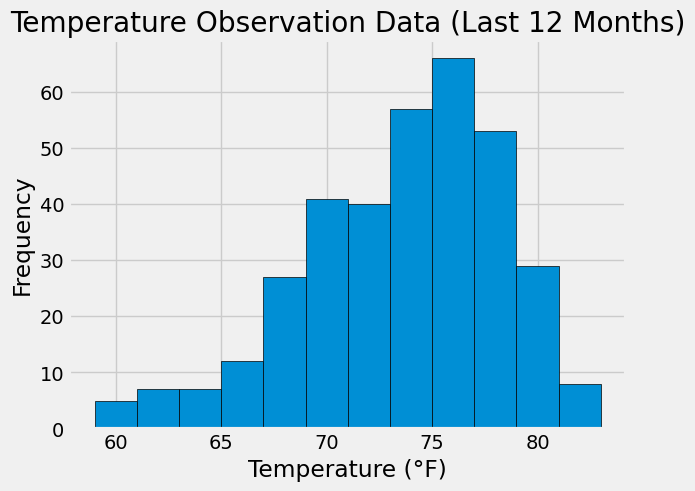

In [153]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(measurement.date, measurement.tobs).filter(
    measurement.station == 'USC00519281',
    measurement.date >= dt.date(2016, 8, 23),
    measurement.date <= dt.date(2017, 8, 23),
).all()

# Convert the results to a DataFrame
df = pd.DataFrame(results, columns=['date', 'temperature'])
df.set_index('date', inplace=True)

# Plot the results as a histogram
plt.hist(df['temperature'], bins=12, edgecolor='black')
plt.title('Temperature Observation Data (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Close Session

In [122]:
# Close Session
session.close()